# List 3
## 1. Implement the HyperLogLog algorithm

Input : stream, b - boxes to which we put an element and then apply the function to find first 1 in the sequence, b is exactly how many firsts element define the box - $2^b$ gives the number of boxes

Output : estimation of the number of different items in the stream


In [1]:
import hashlib
import numpy as np
import math

In [39]:
class HLL:
    def __init__(self,b):
        self.b=b
        self.m=2**b
        self.L_registers={}
        
        if self.b == 4:
            final_alfa = 0.673
        if self.b == 5:
            final_alfa = 0.697
        if self.b == 6:
            final_alfa = 0.709
        else:
            final_alfa = 0.7213 / (1.0 + 1.079 /self.m)
        
        self.alfa=final_alfa
    
    def new_item(self,item):
        
        hashcode=hashlib.md5(str(item).encode('utf-8')).hexdigest()
        hashcode=bin(int(hashcode,32))[2:]
        
        #split the hash representation into a box part and the rest
        box=hashcode[:b]
        rest_after_box=hashcode[b:]
        
        #find the first one position
        first_one_position=rest_after_box.find("1")+1  #mamy nie liczyć od zera pozycję, tylko od jeden
        
        #change the counter value for a box, if box appears for the first time set the counter value to the current one
        #otherwise do the maximum
        try:
            current_L=self.L_registers[box]
            self.L_registers[box]=max(current_L,first_one_position)
        except:
            self.L_registers[box]=first_one_position
    
    def get_counts(self):
        counters=list(self.L_registers.values())
        counters=np.concatenate((np.array(counters), np.zeros(self.m-len(counters)))) #account for zero counters
        return counters
    
    def estimate_counter(self, mode):
        counters=self.get_counts()
        Z=np.sum(np.power(2.0,-counters.astype(float)))
        E=self.alfa*self.m*self.m/Z
        
        if mode=="basic":
            return E
        else:
            if E<=5/2*self.m:
                nr_not_zero_registers=len(self.L_registers)
                V=self.m-nr_not_zero_registers #number of zero boxes, unvisited
                if V!=0:
                    E_corrected=self.m*np.log(self.m/V)
                else:
                    E_corrected=E
        
                return E_corrected
        
            if E<=(1/30)*(2**32):
                E_corrected=E
        
                return E_corrected
        
            if E>(1/30)*(2**32):
                E_corrected=-(2**32)*np.log(1-E/(2**32))
    
                return E_corrected
    

In [3]:
import pandas as pd
data=pd.read_csv("lbl-pkt-4.tcp",sep=" ", header=None,
                 names= ["timestamp", "source host", "destination host","source TCP","destination TCP","nr of data bytes"])

In [48]:
data

,timestamp,source host,destination host,source TCP,destination TCP,nr of data bytes
0,7.591896e+08,1,2,6000,1146,32
1,1.544400e-02,3,4,4695,119,0
2,2.548300e-02,5,6,21,1029,46
3,3.791200e-02,3,4,4695,119,53
4,4.236400e-02,7,8,80,1170,512
...,...,...,...,...,...,...
862941,3.599959e+03,1018,267,1023,514,512
862942,3.599959e+03,131,546,1177,119,0
862943,3.599962e+03,3,4,4731,119,0
862944,3.599978e+03,79,95,2731,80,0


### a) different source hosts

In [50]:
print("exact number of different source hosts: ",len(set(data["source host"])))
bs=[4,5,6,7,8,9,10,11,12,13,14,15,16]
hll_basic=[]
hll_extended=[]
for b in bs:
    hll=HLL(b)
    for item in list(data["source host"]):
        hll.new_item(item)
    
    basic=hll.estimate_counter("basic")
    extend=hll.estimate_counter("extend")
    hll_basic.append(basic)
    hll_extended.append(extend)
    print("b: ", b, " basic HLL: ", basic, " extended HLL: ", extend)

exact number of different source hosts:  997
b:  4  basic HLL:  21.579210044445112  extended HLL:  11.090354888959125
b:  5  basic HLL:  41.63697094306717  extended HLL:  20.240721879792336
b:  6  basic HLL:  84.30687102528499  extended HLL:  40.48144375958467
b:  7  basic HLL:  163.10085770938133  extended HLL:  77.25248279939304
b:  8  basic HLL:  306.82415130626174  extended HLL:  143.76213062943384
b:  9  basic HLL:  553.8721084642567  extended HLL:  239.04435297765986
b:  10  basic HLL:  948.250147816275  extended HLL:  332.6173382668674
b:  11  basic HLL:  1784.549897433827  extended HLL:  510.69585029047147
b:  12  basic HLL:  3350.2289034837095  extended HLL:  691.1684553423825
b:  13  basic HLL:  6371.658585693697  extended HLL:  822.9895443466829
b:  14  basic HLL:  12316.401739363575  extended HLL:  887.6152275275713
b:  15  basic HLL:  24087.055799512622  extended HLL:  916.7039213633368
b:  16  basic HLL:  47743.520803415726  extended HLL:  950.864829900574


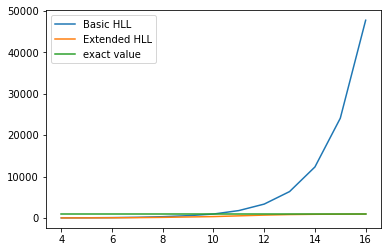

In [44]:
import matplotlib.pyplot as plt
plt.plot(bs, hll_basic, label="Basic HLL")
plt.plot(bs, hll_extended, label="Extended HLL")
plt.plot(bs, np.repeat(997, len(bs)), label="exact value")
plt.legend()

### b) different destination hosts

In [49]:
print("exact number of different destination hosts: ",len(set(data["destination host"])))
bs=[4,5,6,7,8,9,10,11,12,13,14,15,16]
hll_basic=[]
hll_extended=[]
for b in bs:
    hll=HLL(b)
    for item in list(data["destination host"]):
        hll.new_item(item)
    
    basic=hll.estimate_counter("basic")
    extend=hll.estimate_counter("extend")
    hll_basic.append(basic)
    hll_extended.append(extend)
    print("b: ", b, " basic HLL: ", basic, " extended HLL: ", extend)

exact number of different destination hosts:  1010
b:  4  basic HLL:  21.568740997533805  extended HLL:  11.090354888959125
b:  5  basic HLL:  41.60035098091823  extended HLL:  20.240721879792336
b:  6  basic HLL:  84.23299147005513  extended HLL:  40.48144375958467
b:  7  basic HLL:  163.03022849590627  extended HLL:  77.25248279939304
b:  8  basic HLL:  306.6996958637943  extended HLL:  143.76213062943384
b:  9  basic HLL:  555.4011369426078  extended HLL:  240.64185817381664
b:  10  basic HLL:  947.2479239373232  extended HLL:  331.234488630647
b:  11  basic HLL:  1783.5974874749427  extended HLL:  510.69585029047147
b:  12  basic HLL:  3355.3129174832943  extended HLL:  699.463554373023
b:  13  basic HLL:  6376.775861632678  extended HLL:  830.7329788574734
b:  14  basic HLL:  12322.198100970532  extended HLL:  900.2881687292258
b:  15  basic HLL:  24092.786952206632  extended HLL:  929.0466925557921
b:  16  basic HLL:  47750.33943116892  extended HLL:  963.0413387765327


### c) different pairs destination-source

In [54]:
destination=list(data["destination host"])
source=list(data["source host"])
check=[]

for b in bs:
    hll=HLL(b)
    for index in range(len(source)):
        item=str(destination[index])+"-"+str(source[index])
        check.append(item)
        hll.new_item(item)
    basic=hll.estimate_counter("basic")
    extend=hll.estimate_counter("extend")
    hll_basic.append(basic)
    hll_extended.append(extend)
    print("b: ", b, " basic HLL: ", basic, " extended HLL: ", extend)
print("exact: ", len(set(check)))

b:  4  basic HLL:  21.611666974523473  extended HLL:  11.090354888959125
b:  5  basic HLL:  41.90982554268513  extended HLL:  20.240721879792336
b:  6  basic HLL:  85.0718286054255  extended HLL:  40.48144375958467
b:  7  basic HLL:  165.69885374367448  extended HLL:  77.25248279939304
b:  8  basic HLL:  316.02729218944995  extended HLL:  143.76213062943384
b:  9  basic HLL:  582.3414970855481  extended HLL:  251.96617446366952
b:  10  basic HLL:  1028.5517954939469  extended HLL:  393.91886831506355
b:  11  basic HLL:  1948.5865657271831  extended HLL:  686.0973357224566
b:  12  basic HLL:  3629.213235985349  extended HLL:  1075.6441493490277
b:  13  basic HLL:  6773.100094553478  extended HLL:  1454.8697889174948
b:  14  basic HLL:  12788.439295195989  extended HLL:  1690.2661814786688
b:  15  basic HLL:  24526.440461750524  extended HLL:  1768.897046537533
b:  16  basic HLL:  48255.00161576392  extended HLL:  1945.5962059305125
exact:  2126


### Conclusion: 
HLL gives good approximation when b=16 and the correction is applied. 

# 2. Shingles, cleaning and jaccard
Write the procedure with the interface
jaccard(f1:String,f2:String,k:Integer):Double
which for the files named f1 and f2 determines their k-shingles and then calculates their
Jaccard distance. Before determining k-shingles, the files should be cleaned (the minimum is
to delete new line characters, tabs and double spaces).

Apply this procedure to several variants of your program file (use 4-shingles).

Use this procedure to compare subsequent chapters of the book analyzed in Problem 2
(use 7-shingles).

In [19]:
import nltk
from nltk.tokenize import word_tokenize

def clean(filename):
# split into words, remove punctuation marks and lower letters to remove capital letters
    # load data
    file = open(filename, 'rt',encoding="latin-1")
    text = file.read()
    file.close()
    # split into words
    tokens = word_tokenize(text)
    # remove all tokens that are not alphabetic
    words = [word.lower() for word in tokens if word.isalpha()]
    return words

In [20]:
def shingles(k,list_of_words):
    k_shingles=[]
    for i in range(len(list_of_words)-k+1):
        k_shingles.append(tuple(list_of_words[i:i+k]))
    return k_shingles

In [21]:
def jaccard(A,B):
    A=set(A)
    B=set(B)
    try:
        jaccard=len(A.intersection(B))/len(A.union(B))
        #print("A.intersection(B)",A.intersection(B))
        #print("A.union(B)",A.union(B))
        return jaccard
    except:
        print("incorrect arguments")

### Example

In [108]:
%pprint
#read and clean
w = clean("alice's_adventures.txt")
w[1:50]

Pretty printing has been turned OFF


['adventures', 'in', 'wonderland', 'by', 'lewis', 'carroll', 'the', 'millennium', 'fulcrum', 'edition', 'contents', 'chapter', 'i', 'down', 'the', 'chapter', 'ii', 'the', 'pool', 'of', 'tears', 'chapter', 'iii', 'a', 'and', 'a', 'long', 'tale', 'chapter', 'iv', 'the', 'rabbit', 'sends', 'in', 'a', 'little', 'bill', 'chapter', 'advice', 'from', 'a', 'caterpillar', 'chapter', 'vi', 'pig', 'and', 'pepper', 'chapter', 'vii']

In [109]:
#how shingles work
w1=shingles(2,["ala","ma","kota","kot","ma","alę"])
print(w1)
w2=shingles(2,["kot","ma","lubi","alę","ala","lubi","kota"])
print(w2)

[('ala', 'ma'), ('ma', 'kota'), ('kota', 'kot'), ('kot', 'ma'), ('ma', 'alę')]
[('kot', 'ma'), ('ma', 'lubi'), ('lubi', 'alę'), ('alę', 'ala'), ('ala', 'lubi'), ('lubi', 'kota')]


In [106]:
jaccard(w1,w2)

A.intersection(B) {('kot', 'ma')}
A.union(B) {('ma', 'kota'), ('ma', 'lubi'), ('kot', 'ma'), ('kota', 'kot'), ('alę', 'ala'), ('ala', 'lubi'), ('lubi', 'alę'), ('ala', 'ma'), ('ma', 'alę'), ('lubi', 'kota')}


0.1

### Compare documents

In [6]:
K=7
books=["moby_dick.txt","alice's_adventures.txt","dracula.txt","frankenstein.txt","pride_and_prejudice.txt",
                   "the_happy_prince_and_other_tales.txt","the_masque_of_red_death.txt","the_oddyssey.txt",
                   "the_picture_of_dorian_grey.txt","the_yellow_wallpaper.txt"]
texts=[clean(i) for i in books]
text_shingles=[shingles(K,i) for i in texts]

In [9]:
from itertools import *
for combo in combinations(range(len(text_shingles)), 2):  # 2 for pairs, 3 for triplets, etc
    i=combo[0]
    j=combo[1]
    print("book 1: ", books[i], " book 2: ", books[j], jaccard(text_shingles[i],text_shingles[j]))

book 1:  moby_dick.txt  book 2:  alice's_adventures.txt 0.0
book 1:  moby_dick.txt  book 2:  dracula.txt 1.656232402530723e-05
book 1:  moby_dick.txt  book 2:  frankenstein.txt 0.0
book 1:  moby_dick.txt  book 2:  pride_and_prejudice.txt 9.387555855957342e-06
book 1:  moby_dick.txt  book 2:  the_happy_prince_and_other_tales.txt 0.0
book 1:  moby_dick.txt  book 2:  the_masque_of_red_death.txt 0.0
book 1:  moby_dick.txt  book 2:  the_oddyssey.txt 3.063800583347631e-06
book 1:  moby_dick.txt  book 2:  the_picture_of_dorian_grey.txt 0.0
book 1:  moby_dick.txt  book 2:  the_yellow_wallpaper.txt 0.0
book 1:  alice's_adventures.txt  book 2:  dracula.txt 1.6422968068275752e-05
book 1:  alice's_adventures.txt  book 2:  frankenstein.txt 0.0
book 1:  alice's_adventures.txt  book 2:  pride_and_prejudice.txt 7.144183919870833e-06
book 1:  alice's_adventures.txt  book 2:  the_happy_prince_and_other_tales.txt 0.0
book 1:  alice's_adventures.txt  book 2:  the_masque_of_red_death.txt 0.0
book 1:  alice

# 3. Min hash
Apply the min-hash method to the previous problem. Your procedure should
depend on the H parameter, which determines the number of hash functions used to build the
signature.
Test this procedure on the data from the previous problem for H ∈ {50, 100, 250} and
compare the Jaccard distance approximation with its exact values. Remember to generate a
shared family of hash functions for all analyzed texts.

Algorithm:

1. First set the set of hash functions - murmur hash functions with a seed. Generate random sample of seeds and use them from this moment for further calls of hash functions.

2. Go through each document of the corpus and create its signature. For each hash function hash all shingles of the document and take the lowest value - it will be the next element of the signature.

3. Having the sigantures for each document compare them in pairwisely. Calculate at how many indexes the values in the signatures for both documents are the same. Divide this number by number of hashes applied - the length of the signature.

In this way we obtain an approximation of the Jaccard similarity. The basic idea is to shuffle the set of all elements across all documents and check at which position in shuffle the first element appears in the document. Then the probability of agreement (all elements: ["a,"b","c","d"] -> shuffle ["b","c","d","a"], first set ["a","b"] first index of appearence is after shuffling 1) is equal to Jaccard. However, shuffling is expensive that we simulate shuffling by applying hash functions that work as uniformly distributed random variables.


In [23]:
import mmh3
import random
def make_signature(shingles_list, seed_values):
    signature=[min([mmh3.hash(shingle, seed) for shingle in shingles_list]) for seed in seed_values]
    return signature

In [40]:
def calculate_similarity(signature1, signature2):
    m=len(signature1)
    sim=[1 for i in range(m) if signature1[i]==signature2[i]]
    return sum(sim)/m

In [30]:
def shingles2(k,list_of_words):
    k_shingles=[]
    for i in range(len(list_of_words)-k+1):
        k_shingles.append(str(tuple(list_of_words[i:i+k])))
    return k_shingles

In [71]:
from itertools import *
def run(documents, number_of_hashes, K):
    signatures={}
    seed_values=random.sample(range(5000), number_of_hashes)
    
    for i in documents:
        file=clean(i)
        list_shingles=shingles2(K,file)
        signature=make_signature(list_shingles,seed_values)
        signatures[i]=signature
        
    v1=[]
    v2=[]
    
    for combo in combinations(range(len(documents)), 2):  # 2 for pairs, 3 for triplets, etc
        i=combo[0]
        j=combo[1]
        book1=documents[i]
        book2=documents[j]
        signature1=signatures[book1]
        signature2=signatures[book2]
        
        text1=clean(book1)
        text2=clean(book2)
        text_shingles1=shingles(K,text1)
        text_shingles2=shingles(K,text2)
        
        #print("Pair: ", book1, " - ", book2," : ", calculate_similarity(signature1,signature2),
         #    " exact value: ",jaccard(text_shingles1,text_shingles2))
        v1.append(calculate_similarity(signature1,signature2))
        v2.append(jaccard(text_shingles1,text_shingles2))
        
    return v1, v2 

In [64]:
books=["moby_dick.txt","alice's_adventures.txt","dracula.txt","frankenstein.txt","pride_and_prejudice.txt",
                   "the_happy_prince_and_other_tales.txt","the_masque_of_red_death.txt","the_oddyssey.txt",
                   "the_picture_of_dorian_grey.txt","the_yellow_wallpaper.txt"]
H=50
K=3
run(books, H, K)

Pair:  moby_dick.txt  -  alice's_adventures.txt  :  0.0  exact value:  0.009267416222457806
Pair:  moby_dick.txt  -  dracula.txt  :  0.0  exact value:  0.028431272758316122
Pair:  moby_dick.txt  -  frankenstein.txt  :  0.0  exact value:  0.016713080514374642
Pair:  moby_dick.txt  -  pride_and_prejudice.txt  :  0.0  exact value:  0.021146015125072717
Pair:  moby_dick.txt  -  the_happy_prince_and_other_tales.txt  :  0.0  exact value:  0.007833288640442254
Pair:  moby_dick.txt  -  the_masque_of_red_death.txt  :  0.0  exact value:  0.0014197205163213463
Pair:  moby_dick.txt  -  the_oddyssey.txt  :  0.0  exact value:  0.0251629921231115
Pair:  moby_dick.txt  -  the_picture_of_dorian_grey.txt  :  0.0  exact value:  0.01679829621084391
Pair:  moby_dick.txt  -  the_yellow_wallpaper.txt  :  0.0  exact value:  0.003415454126917847
Pair:  alice's_adventures.txt  -  dracula.txt  :  0.0  exact value:  0.015800737367743827
Pair:  alice's_adventures.txt  -  frankenstein.txt  :  0.0  exact value:  0.0

In [72]:
H=50
K=3
estimate, exact = run(books, H, K)

In [74]:
H=100
estimate2, exact2 = run(books, H, K)

In [75]:
H=250
estimate3, exact3 = run(books, H, K)

Text(0.5, 1.0, 'Minhash vs Jaccard')

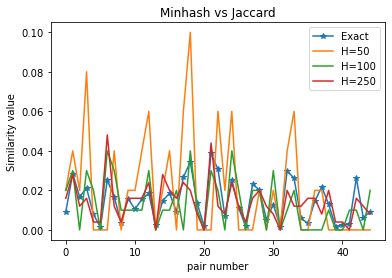

In [77]:
import matplotlib.pyplot as plt
plt.plot(exact,"-*",label="Exact" )
plt.plot(estimate,label="H=50")
plt.plot(estimate2,label="H=100")
plt.plot(estimate3,label="H=250")
plt.xlabel("pair number")
plt.ylabel("Similarity value")
plt.legend()
plt.title("Minhash vs Jaccard")

H number of hash functions used- length of signature
Conclusion: 100 is enough to get a good estimate, 50 has high variance.